In [1]:
import argparse
from pathlib import Path
from pointcept.supplemental.utils import disable_trame_logger
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import GridSplitter, process_folds
import numpy as np
import pyvista as pv


disable_trame_logger()
set_data_root("../data")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler("rog_north")
dh.ensure_meshes()

21:49:06 - INFO - Label rog_north already has extracted meshes.


In [3]:
analyser = MeshAnalyser(data_handler=dh)

In [4]:
to_exclude = ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING']
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

21:49:07 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '8_DOOR', '9_WINDOW', '11_RAILING', '12_RWP', '13_OTHER'].
21:49:07 - INFO - Sampling with resolution 0.15.
21:49:07 - WARNING - Category '1_WALL' not found in meshes.
21:49:07 - WARNING - Category '2_FLOOR' not found in meshes.
21:49:07 - WARNING - Category '3_ROOF' not found in meshes.
21:49:07 - WARNING - Category '4_CEILING' not found in meshes.
21:49:07 - INFO - Number of points after initial sampling: 520125
21:49:07 - INFO - Number of points after Poisson Disk Sampling: 132001
21:49:07 - INFO - Number of points after initial sampling: 42102
21:49:07 - INFO - Number of points after Poisson Disk Sampling: 11823
21:49:07 - INFO - Number of points after initial sampling: 384820
21:49:07 - INFO - Number of points after Poisson Disk Sampling: 10120
21:49:07 - INFO - Number of points after initial sampling: 1197013
21:49:08 - INFO - Number of points after Po

In [5]:
binning = analyser.evaluate_binning(pcds, x_cell_width=8.0, y_cell_width=8.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

21:49:08 - INFO - Binning is using 9 bins in X and 8 bins in Y based on cell widths of 8.0 and 8.0.


21:49:08 - INFO - New best equality score: 16047456.3456 at iteration 1
21:49:08 - INFO - New best equality score: 12075626.6902 at iteration 2
21:49:08 - INFO - New best equality score: 5047329.0274 at iteration 7
21:49:08 - INFO - New best equality score: 4076803.8939 at iteration 37
21:49:09 - INFO - New best equality score: 4046630.6917 at iteration 247
21:49:09 - INFO - New best equality score: 4046176.0070 at iteration 731
21:49:10 - INFO - New best equality score: 4033834.0771 at iteration 1013
21:49:10 - INFO - New best equality score: 3031448.3580 at iteration 1063
21:49:13 - INFO - New best equality score: 3028629.3037 at iteration 4031
21:49:14 - INFO - 
Best equality score after 5000 iterations: 3028629.3037
21:49:14 - INFO - Best iteration: 4031
21:49:14 - INFO - 
Final category counts per area:

Area 1:
  Area size: 14 cells (19.44% of total, intended 20.00%)
  5_FOOTPATH: 38833 points (29.42% of total 5_FOOTPATH)
  6_GRASS: 0 points (0.00% of total 6_GRASS)
  8_DOOR: 100

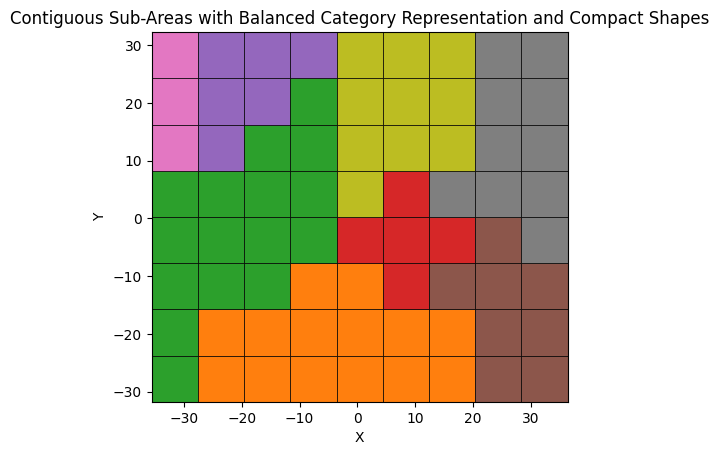

In [6]:
weights = [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]  # Intended area weights: training, evaluation, test
iterations = 5000  # Number of iterations to run
min_percentage_threshold = 3  # Minimum acceptable percentage per category per area
verbose = True  # Whether to print detailed statistics

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    min_percentage_threshold=min_percentage_threshold,
    verbose=verbose
)

# Run the algorithm
grid_splitter.run()

# Plot the result
grid_splitter.plot()

In [7]:
best_grid = grid_splitter.best_grid
best_grid

array([[2, 1, 1, 1, 1, 1, 1, 5, 5],
       [2, 1, 1, 1, 1, 1, 1, 5, 5],
       [2, 2, 2, 1, 1, 3, 5, 5, 5],
       [2, 2, 2, 2, 3, 3, 3, 5, 7],
       [2, 2, 2, 2, 8, 3, 7, 7, 7],
       [6, 4, 2, 2, 8, 8, 8, 7, 7],
       [6, 4, 4, 2, 8, 8, 8, 7, 7],
       [6, 4, 4, 4, 8, 8, 8, 7, 7]])

In [8]:
x_edges

array([-35.58550262, -27.58550262, -19.58550262, -11.58550262,
        -3.58550262,   4.41449738,  12.41449738,  20.41449738,
        28.41449738,  36.41449738])

In [9]:
y_edges

array([-31.75650215, -23.75650215, -15.75650215,  -7.75650215,
         0.24349785,   8.24349785,  16.24349785,  24.24349785,
        32.24349785])

Processing Fold 1
Fold 1 has 2 rectangles with total perimeter 22.


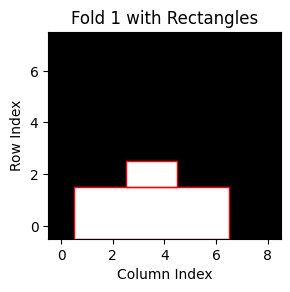

Processing Fold 2
Fold 2 has 4 rectangles with total perimeter 32.


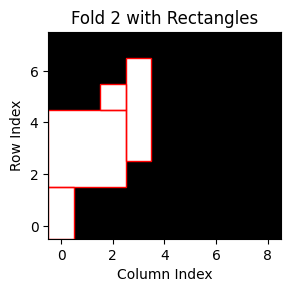

Processing Fold 3
Fold 3 has 3 rectangles with total perimeter 16.


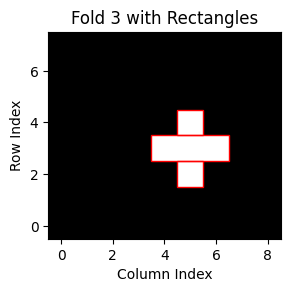

Processing Fold 4
Fold 4 has 3 rectangles with total perimeter 16.


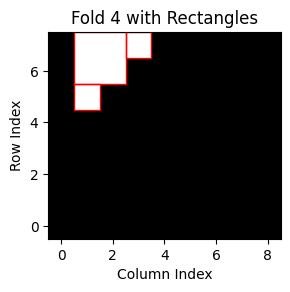

Processing Fold 5
Fold 5 has 3 rectangles with total perimeter 18.


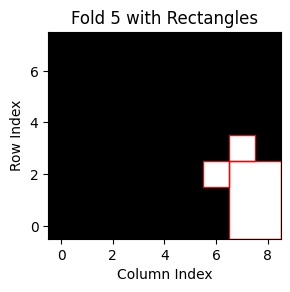

Processing Fold 6
Fold 6 has 1 rectangles with total perimeter 8.


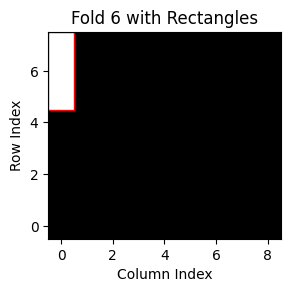

Processing Fold 7
Fold 7 has 3 rectangles with total perimeter 20.


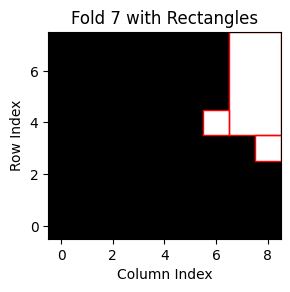

Processing Fold 8
Fold 8 has 2 rectangles with total perimeter 16.


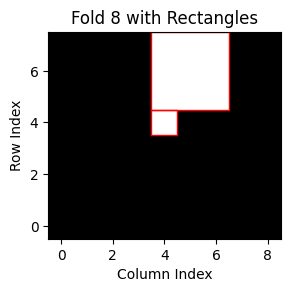

In [10]:
# Process the folds and get the rectangles
fold_rectangles = process_folds(best_grid)

In [11]:
# Output the rectangles for each fold
for fold_id, rectangles in fold_rectangles.items():
    print(f"\nRectangles for Fold {fold_id}:")
    for idx, rect in enumerate(rectangles):
        min_row, max_row = rect['min_row'], rect['max_row']
        min_col, max_col = rect['min_col'], rect['max_col']
        area = (max_row - min_row + 1) * (max_col - min_col + 1)
        perimeter = 2 * ((max_row - min_row + 1) + (max_col - min_col + 1))
        print(f"  Rectangle {idx + 1}: Rows {min_row} to {max_row}, Cols {min_col} to {max_col}, Area: {area}, Perimeter: {perimeter}")


Rectangles for Fold 1:
  Rectangle 1: Rows 0 to 1, Cols 1 to 6, Area: 12, Perimeter: 16
  Rectangle 2: Rows 2 to 2, Cols 3 to 4, Area: 2, Perimeter: 6

Rectangles for Fold 2:
  Rectangle 1: Rows 2 to 4, Cols 0 to 2, Area: 9, Perimeter: 12
  Rectangle 2: Rows 3 to 6, Cols 3 to 3, Area: 4, Perimeter: 10
  Rectangle 3: Rows 0 to 1, Cols 0 to 0, Area: 2, Perimeter: 6
  Rectangle 4: Rows 5 to 5, Cols 2 to 2, Area: 1, Perimeter: 4

Rectangles for Fold 3:
  Rectangle 1: Rows 3 to 3, Cols 4 to 6, Area: 3, Perimeter: 8
  Rectangle 2: Rows 2 to 2, Cols 5 to 5, Area: 1, Perimeter: 4
  Rectangle 3: Rows 4 to 4, Cols 5 to 5, Area: 1, Perimeter: 4

Rectangles for Fold 4:
  Rectangle 1: Rows 6 to 7, Cols 1 to 2, Area: 4, Perimeter: 8
  Rectangle 2: Rows 5 to 5, Cols 1 to 1, Area: 1, Perimeter: 4
  Rectangle 3: Rows 7 to 7, Cols 3 to 3, Area: 1, Perimeter: 4

Rectangles for Fold 5:
  Rectangle 1: Rows 0 to 2, Cols 7 to 8, Area: 6, Perimeter: 10
  Rectangle 2: Rows 2 to 2, Cols 6 to 6, Area: 1, Perime

In [12]:
category_meshes = dh.extracted_meshes

# Now, we proceed with the implementation
def map_grid_to_spatial(min_col, max_col, min_row, max_row, x_edges, y_edges):
    # Map grid indices to spatial coordinates using x_edges and y_edges
    xmin = x_edges[min_col]
    xmax = x_edges[max_col + 1]  # +1 because x_edges has length grid_size_x + 1
    ymin = y_edges[min_row]
    ymax = y_edges[max_row + 1]  # +1 because y_edges has length grid_size_y + 1
    return xmin, xmax, ymin, ymax

# Process each fold and perform cropping operations
fold_meshes = {}

for fold_id, rectangles in fold_rectangles.items():
    print(f"Processing Fold {fold_id}")
    # For each category, we'll create a list to store cropped meshes
    fold_category_meshes = {}
    for category, mesh in category_meshes.items():
        mesh = pv.wrap(mesh)
        # Initialize an empty list to collect cropped meshes for this category and fold
        cropped_meshes = []
        for rect in rectangles:
            # Map grid indices to spatial coordinates
            xmin, xmax, ymin, ymax = map_grid_to_spatial(
                rect['min_col'], rect['max_col'], rect['min_row'], rect['max_row'], x_edges, y_edges)
            
            # Define the cropping box
            # Since PyVista's clip function uses planes, we'll define the planes accordingly
            # We can use the 'extract_box' method for axis-aligned bounding boxes
            bounds = (xmin, xmax, ymin, ymax, mesh.bounds[4], mesh.bounds[5])
            cropped_mesh = mesh.clip_box(bounds, invert=False)
            
            if cropped_mesh.n_points > 0:
                cropped_meshes.append(cropped_mesh)
        
        # Merge the cropped meshes for this category and fold
        if cropped_meshes:
            combined_mesh = cropped_meshes[0]
            for cm in cropped_meshes[1:]:
                combined_mesh = combined_mesh.merge(cm)
            fold_category_meshes[category] = combined_mesh
        else:
            print(f"No mesh data in Fold {fold_id} for category {category}")
    
    # Store the combined meshes per fold
    fold_meshes[fold_id] = fold_category_meshes

Processing Fold 1
No mesh data in Fold 1 for category 6_GRASS
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
No mesh data in Fold 5 for category 6_GRASS
Processing Fold 6
No mesh data in Fold 6 for category 6_GRASS
Processing Fold 7
Processing Fold 8


In [13]:
colors = {1: 'red', 2: 'green', 3: 'blue', 4: 'purple', 5: 'cyan', 6: 'orange', 7: 'grey', 8: 'yellow'}
pv.set_jupyter_backend('trame')  # Or 'panel', 'ipygany', etc.
p = pv.Plotter(notebook=True)

for fold_id, category_meshes in fold_meshes.items():
    print(f"Visualizing Fold {fold_id}")
    for category, mesh in category_meshes.items():
        p.add_mesh(mesh, color=colors[fold_id], show_edges=True, opacity=0.7)

p.show(title=f"Fold {fold_id} Meshes")

21:49:38 - INFO - Translator(prefix=None)


Visualizing Fold 1
Visualizing Fold 2
Visualizing Fold 3
Visualizing Fold 4
Visualizing Fold 5
Visualizing Fold 6
Visualizing Fold 7
Visualizing Fold 8


21:49:38 - INFO - awaiting runner setup
21:49:38 - INFO - awaiting site startup
21:49:38 - INFO - Print WSLINK_READY_MSG
21:49:38 - INFO - Schedule auto shutdown with timout 0
21:49:38 - INFO - awaiting running future
21:49:38 - INFO - trigger(trigger__1)
21:49:38 - INFO - trigger(trigger__2)
21:49:38 - INFO - trigger(P_0x7fad2076c0d0_0Camera)
21:49:38 - INFO - trigger(P_0x7fad2076c0d0_0AnimateStart)
21:49:38 - INFO - trigger(P_0x7fad2076c0d0_0AnimateStop)
21:49:39 - INFO - js_key = class
21:49:39 - INFO - js_key = style
21:49:39 - INFO - js_key = fluid
21:49:39 - INFO - js_key = class
21:49:39 - INFO - before: class = { 'rounded-circle': !P_0x7fad2076c0d0_0_show_ui }
21:49:39 - INFO - (prefix=None) token {
21:49:39 - INFO - has({ => {) = False
21:49:39 - INFO - (prefix=None) token  
21:49:39 - INFO - has(  =>  ) = False
21:49:39 - INFO - (prefix=None) token '
21:49:39 - INFO - has(' => ') = False
21:49:39 - INFO - (prefix=None) token rounded
21:49:39 - INFO - has(rounded => rounded) =

Widget(value='<iframe src="http://localhost:42771/index.html?ui=P_0x7fad2076c0d0_0&reconnect=auto" class="pyvi…

In [14]:
grid_splitter.best_area_category_counts

{1: {'5_FOOTPATH': 38833.0,
  '6_GRASS': 0.0,
  '8_DOOR': 1004.0,
  '9_WINDOW': 2648.0,
  '11_RAILING': 3607.0,
  '12_RWP': 154.0,
  '13_OTHER': 2456.0},
 2: {'5_FOOTPATH': 31646.0,
  '6_GRASS': 1820.0,
  '8_DOOR': 935.0,
  '9_WINDOW': 2340.0,
  '11_RAILING': 3033.0,
  '12_RWP': 168.0,
  '13_OTHER': 6590.0},
 3: {'5_FOOTPATH': 17788.0,
  '6_GRASS': 224.0,
  '8_DOOR': 1032.0,
  '9_WINDOW': 2907.0,
  '11_RAILING': 1893.0,
  '12_RWP': 123.0,
  '13_OTHER': 3806.0},
 4: {'5_FOOTPATH': 5237.0,
  '6_GRASS': 1224.0,
  '8_DOOR': 1657.0,
  '9_WINDOW': 2022.0,
  '11_RAILING': 1997.0,
  '12_RWP': 187.0,
  '13_OTHER': 9584.0},
 5: {'5_FOOTPATH': 7707.0,
  '6_GRASS': 0.0,
  '8_DOOR': 3458.0,
  '9_WINDOW': 6286.0,
  '11_RAILING': 2673.0,
  '12_RWP': 263.0,
  '13_OTHER': 17325.0},
 6: {'5_FOOTPATH': 7265.0,
  '6_GRASS': 0.0,
  '8_DOOR': 834.0,
  '9_WINDOW': 1023.0,
  '11_RAILING': 3684.0,
  '12_RWP': 137.0,
  '13_OTHER': 3216.0},
 7: {'5_FOOTPATH': 15593.0,
  '6_GRASS': 3251.0,
  '8_DOOR': 793.0,
  '9